In [27]:
import numpy as np
import matplotlib.pyplot as plt

import io 
import pandas as pd  
import pyreadr

from load_data import *
from pred_score import *
from Filter_FS import *
from hybrid_FS import *
from overlap_genes import *

In [28]:
#Fixing seed to get reproducible results
random.seed(3)
np.random.seed(3)

# Baseline with preselected genes 

In [29]:
#Load preprocess data
LK = np.array(pd.read_csv ('../data/processed_data/LK.csv'))
y = np.array(LK[:,-1],dtype=int)
LK = LK[:,0:-1]

In [30]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(LK,y)

In [31]:
print(LK.shape, len(pred))
acc = model.score_
print(acc)

(610, 1379) 610
0.136


In [32]:
print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (102.0, 648.0, 0.1574074074074074, 0.37777777777777777, 0.9876770942283921, 0.136, 0.9967757412916227, 0.864, 0.6222222222222222)


In [33]:
def split_data_cv(x:np.array, y:np.array, kfold:int):
    """ Split the data for CV. Keep cells of same family together.
  
      parameters:
      y: np.array,
        family of each data points
      x: np.array,
        gene expression of each data points
      kfold: int,
        number of fold for CV
        

      returns:
      split_x : np.array of np.array,
        split normalized data, split_x[k] = kth split
      split_y : np.array of np.array,
        split families data   """
    
    #Get all families indices
    ind_families = np.unique(y)
    N_families = len(ind_families)
    N_fold_family = math.ceil(N_families/kfold)
    
    
    #Randomly choose the families in each split    
    np.random.shuffle(ind_families)
    
    fam_split = np.empty(kfold, dtype=object)
    for i in range (0,kfold):
        fam_split[i] = []
        
    for i in range (0, kfold):
        temp = ind_families[i*N_fold_family:((i+1)*N_fold_family)]
        fam_split[i].append(temp)
      
    #Get the data from splitted families: split_x, split_y
    split_x = np.empty(kfold, dtype=object)
    split_y = np.empty(kfold, dtype=object)
    for i in range (0,kfold):
        split_x[i] = []
        split_y[i] = []
        
    for i in range (0,kfold):
        ind = np.squeeze(fam_split[i])
     
        mask = np.isin(y, ind)
        temp_x = x[mask]
        temp_y = y[mask]
        
        split_x[i].append(temp_x)
        split_y[i].append(temp_y)
            
        
    return split_x, split_y



In [34]:
fam = np.array([1,7,1,1,7,8,10,4,6])
x = np.array([1,68,3,20,9,2,24,8,20])

split_x, split_y = split_data_cv(x,fam,3)

# Split data into Kfold (kfold = 5)

In [35]:
split_x, split_y = split_data_cv(LK,y,5)

# Mutual information maximizer (MIM)

(485, 1379) (125, 1379) (485,) (125,)
(486, 1379) (124, 1379) (486,) (124,)
(490, 1379) (120, 1379) (490,) (120,)
(491, 1379) (119, 1379) (491,) (119,)
(488, 1379) (122, 1379) (488,) (122,)
training 0.2624575282004308 0.006827700370294153
test 0.5231034675712003 0.0678348059290524


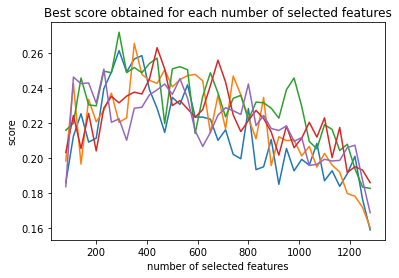

In [36]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    N = np.arange(80,1300,30)
    subset, train_score = MIM(y_train, x_train, FamiliesClusters, compute_precision,True,N, 3, plot=True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

# Anova F test

(485, 1379) (125, 1379) (485,) (125,)
(486, 1379) (124, 1379) (486,) (124,)
(490, 1379) (120, 1379) (490,) (120,)
(491, 1379) (119, 1379) (491,) (119,)
(488, 1379) (122, 1379) (488,) (122,)
training 0.33337639684075626 0.019601715820366985
test 0.549694019203183 0.08317354029677564


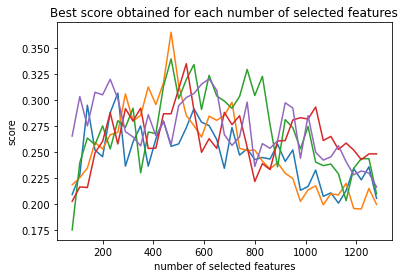

In [11]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    N = np.arange(80,1300,30)
    subset, train_score = ANOVA(y_train, x_train, FamiliesClusters, compute_ratio,True,N, plot=True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

# Stimulated annealing

(485, 1379) (125, 1379) (485,) (125,)


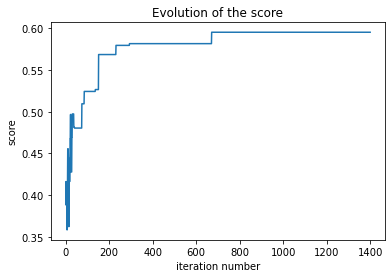

(486, 1379) (124, 1379) (486,) (124,)


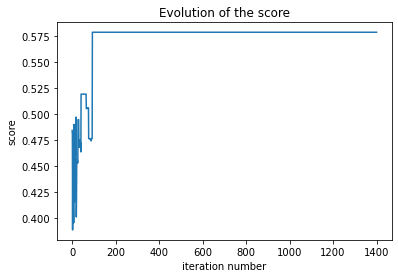

(490, 1379) (120, 1379) (490,) (120,)


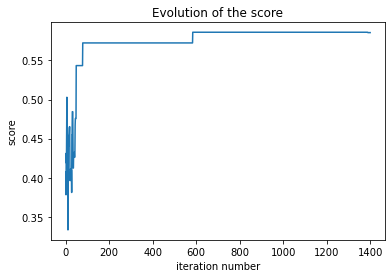

(491, 1379) (119, 1379) (491,) (119,)


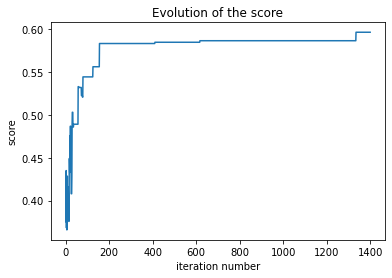

(488, 1379) (122, 1379) (488,) (122,)


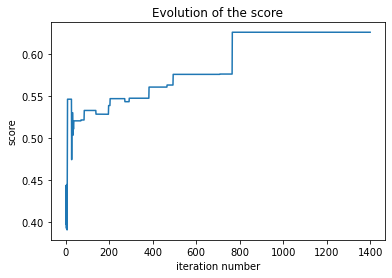

training 0.5964143257952201 0.016026197403096368
test 0.34918759219154477 0.07056141947509452


In [14]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    subset, train_score = stimulated_annealing(y_train, x_train, FamiliesClusters, compute_sensitivity,True, 1400, 0.1, 1, True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

# Genetic feature selection algorithm

(485, 1379) (125, 1379) (485,) (125,)


/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dormann/Desktop/GitHub/src/pred_score.py", line 326, in fit
    Z = ward(corr_expr)
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 834, in ward
    return linkage(y, method='ward', metric='euclidean')
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 1065, in linkage
    raise ValueError("The condensed distance matrix must contain only "
ValueError: The condensed distance matrix must contain only finite values.

  warnings.warn("E

/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dormann/Desktop/GitHub/src/pred_score.py", line 326, in fit
    Z = ward(corr_expr)
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 834, in ward
    return linkage(y, method='ward', metric='euclidean')
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 1065, in linkage
    raise ValueError("The condensed distance matrix must contain only "
ValueError: The condensed distance matrix must contain only finite values.

  warnings.warn("E

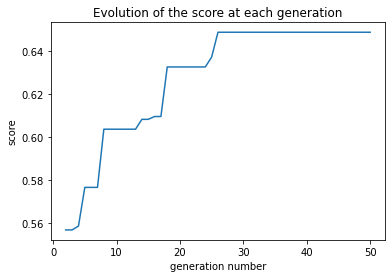

(486, 1379) (124, 1379) (486,) (124,)


/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dormann/Desktop/GitHub/src/pred_score.py", line 326, in fit
    Z = ward(corr_expr)
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 834, in ward
    return linkage(y, method='ward', metric='euclidean')
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 1065, in linkage
    raise ValueError("The condensed distance matrix must contain only "
ValueError: The condensed distance matrix must contain only finite values.

  warnings.warn("E

/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dormann/Desktop/GitHub/src/pred_score.py", line 326, in fit
    Z = ward(corr_expr)
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 834, in ward
    return linkage(y, method='ward', metric='euclidean')
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 1065, in linkage
    raise ValueError("The condensed distance matrix must contain only "
ValueError: The condensed distance matrix must contain only finite values.

  warnings.warn("E

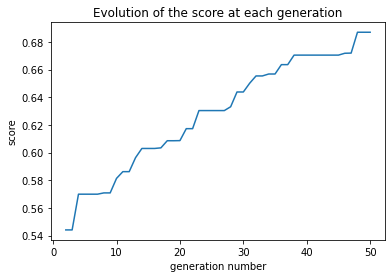

(490, 1379) (120, 1379) (490,) (120,)


/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dormann/Desktop/GitHub/src/pred_score.py", line 326, in fit
    Z = ward(corr_expr)
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 834, in ward
    return linkage(y, method='ward', metric='euclidean')
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 1065, in linkage
    raise ValueError("The condensed distance matrix must contain only "
ValueError: The condensed distance matrix must contain only finite values.

  warnings.warn("E

/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dormann/Desktop/GitHub/src/pred_score.py", line 326, in fit
    Z = ward(corr_expr)
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 834, in ward
    return linkage(y, method='ward', metric='euclidean')
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 1065, in linkage
    raise ValueError("The condensed distance matrix must contain only "
ValueError: The condensed distance matrix must contain only finite values.

  warnings.warn("E

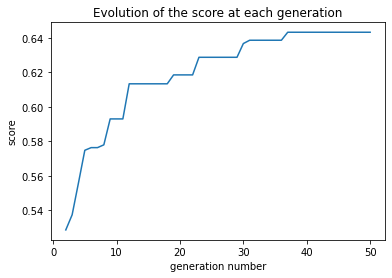

(491, 1379) (119, 1379) (491,) (119,)


/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dormann/Desktop/GitHub/src/pred_score.py", line 326, in fit
    Z = ward(corr_expr)
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 834, in ward
    return linkage(y, method='ward', metric='euclidean')
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 1065, in linkage
    raise ValueError("The condensed distance matrix must contain only "
ValueError: The condensed distance matrix must contain only finite values.

  warnings.warn("E

/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dormann/Desktop/GitHub/src/pred_score.py", line 326, in fit
    Z = ward(corr_expr)
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 834, in ward
    return linkage(y, method='ward', metric='euclidean')
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 1065, in linkage
    raise ValueError("The condensed distance matrix must contain only "
ValueError: The condensed distance matrix must contain only finite values.

  warnings.warn("E

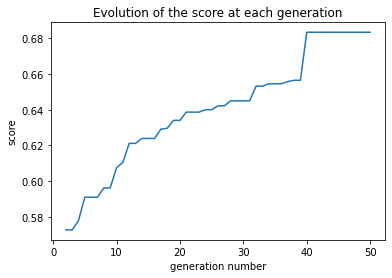

(488, 1379) (122, 1379) (488,) (122,)


/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dormann/Desktop/GitHub/src/pred_score.py", line 326, in fit
    Z = ward(corr_expr)
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 834, in ward
    return linkage(y, method='ward', metric='euclidean')
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 1065, in linkage
    raise ValueError("The condensed distance matrix must contain only "
ValueError: The condensed distance matrix must contain only finite values.

  warnings.warn("E

/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dormann/Desktop/GitHub/src/pred_score.py", line 326, in fit
    Z = ward(corr_expr)
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 834, in ward
    return linkage(y, method='ward', metric='euclidean')
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 1065, in linkage
    raise ValueError("The condensed distance matrix must contain only "
ValueError: The condensed distance matrix must contain only finite values.

  warnings.warn("E

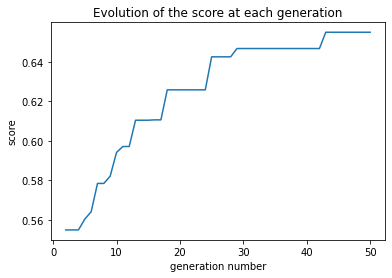

training 0.6634382933694495 0.01816668008538974
test 0.34434401211425336 0.0560483226498452


In [15]:


score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    subset, train_score = genetic_fs(y_train,x_train,FamiliesClusters,compute_sensitivity,True, 500, 0.5, 0.2, 50, 3, True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

# Hybrid methods

# Mutual information and stimulated annealing

(485, 1379) (125, 1379) (485,) (125,)


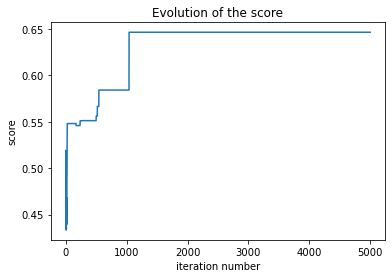

(486, 1379) (124, 1379) (486,) (124,)


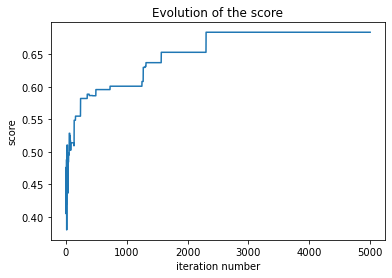

(490, 1379) (120, 1379) (490,) (120,)


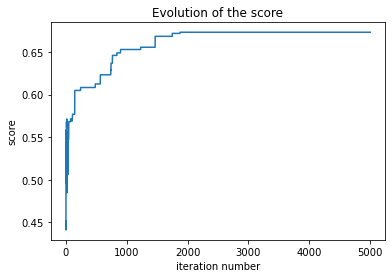

(491, 1379) (119, 1379) (491,) (119,)


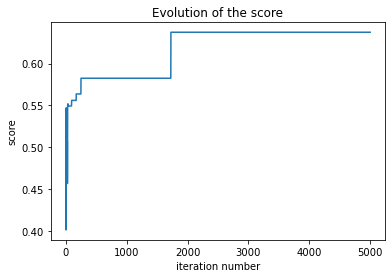

(488, 1379) (122, 1379) (488,) (122,)


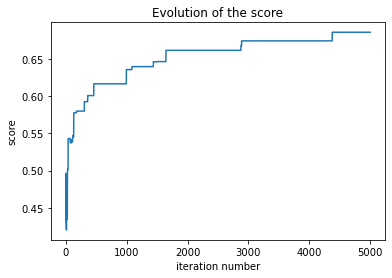

training 0.6654208925620081 0.019939065194234478
test 0.44689024805536065 0.13291358068675846


In [16]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    subset, train_score = MI_stimulated_annealing(y_train,x_train, FamiliesClusters, compute_sensitivity,True, np.array([400]), 3, 5000, 0.05, 1, True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

# Mutual information and genetic feature selection

(485, 1379) (125, 1379) (485,) (125,)


/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dormann/Desktop/GitHub/src/pred_score.py", line 326, in fit
    Z = ward(corr_expr)
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 834, in ward
    return linkage(y, method='ward', metric='euclidean')
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 1065, in linkage
    raise ValueError("The condensed distance matrix must contain only "
ValueError: The condensed distance matrix must contain only finite values.

  warnings.warn("E

/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dormann/Desktop/GitHub/src/pred_score.py", line 326, in fit
    Z = ward(corr_expr)
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 834, in ward
    return linkage(y, method='ward', metric='euclidean')
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 1065, in linkage
    raise ValueError("The condensed distance matrix must contain only "
ValueError: The condensed distance matrix must contain only finite values.

  warnings.warn("E

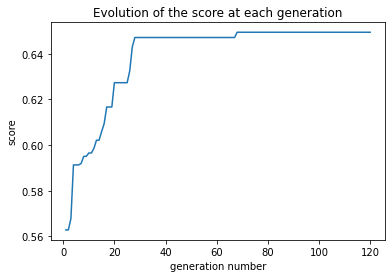

(486, 1379) (124, 1379) (486,) (124,)


/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dormann/Desktop/GitHub/src/pred_score.py", line 326, in fit
    Z = ward(corr_expr)
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 834, in ward
    return linkage(y, method='ward', metric='euclidean')
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 1065, in linkage
    raise ValueError("The condensed distance matrix must contain only "
ValueError: The condensed distance matrix must contain only finite values.

  warnings.warn("E

/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dormann/Desktop/GitHub/src/pred_score.py", line 326, in fit
    Z = ward(corr_expr)
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 834, in ward
    return linkage(y, method='ward', metric='euclidean')
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 1065, in linkage
    raise ValueError("The condensed distance matrix must contain only "
ValueError: The condensed distance matrix must contain only finite values.

  warnings.warn("E

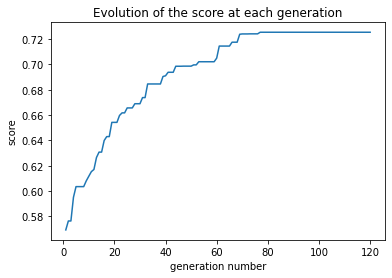

(490, 1379) (120, 1379) (490,) (120,)


/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dormann/Desktop/GitHub/src/pred_score.py", line 326, in fit
    Z = ward(corr_expr)
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 834, in ward
    return linkage(y, method='ward', metric='euclidean')
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 1065, in linkage
    raise ValueError("The condensed distance matrix must contain only "
ValueError: The condensed distance matrix must contain only finite values.

  warnings.warn("E

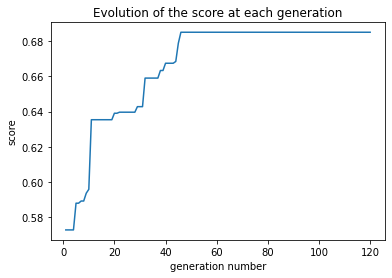

(491, 1379) (119, 1379) (491,) (119,)


/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dormann/Desktop/GitHub/src/pred_score.py", line 326, in fit
    Z = ward(corr_expr)
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 834, in ward
    return linkage(y, method='ward', metric='euclidean')
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 1065, in linkage
    raise ValueError("The condensed distance matrix must contain only "
ValueError: The condensed distance matrix must contain only finite values.

  warnings.warn("E

/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dormann/Desktop/GitHub/src/pred_score.py", line 326, in fit
    Z = ward(corr_expr)
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 834, in ward
    return linkage(y, method='ward', metric='euclidean')
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 1065, in linkage
    raise ValueError("The condensed distance matrix must contain only "
ValueError: The condensed distance matrix must contain only finite values.

  warnings.warn("E

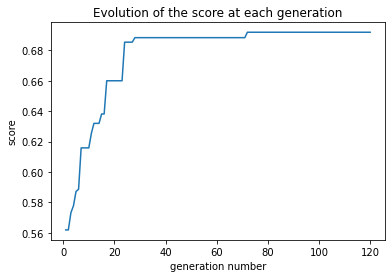

(488, 1379) (122, 1379) (488,) (122,)


/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dormann/Desktop/GitHub/src/pred_score.py", line 326, in fit
    Z = ward(corr_expr)
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 834, in ward
    return linkage(y, method='ward', metric='euclidean')
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 1065, in linkage
    raise ValueError("The condensed distance matrix must contain only "
ValueError: The condensed distance matrix must contain only finite values.

  warnings.warn("E

/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dormann/Desktop/GitHub/src/pred_score.py", line 326, in fit
    Z = ward(corr_expr)
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 834, in ward
    return linkage(y, method='ward', metric='euclidean')
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 1065, in linkage
    raise ValueError("The condensed distance matrix must contain only "
ValueError: The condensed distance matrix must contain only finite values.

  warnings.warn("E

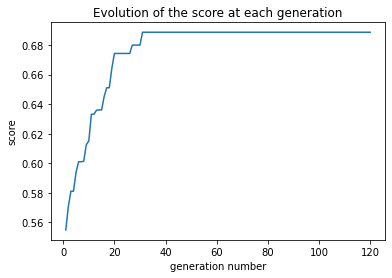

training 0.6881229005637761 0.024121332333129887
test 0.38597089440627674 0.04210348892016588


In [17]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    subset, train_score = MI_genetic_fs(y_train,x_train, FamiliesClusters, compute_sensitivity,True, np.array([700]), 3,  300, 0.5, 0.2, 120, 3, True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

# Baseline with preselected genes 

In [18]:
#Load preprocess data
LK = np.array(pd.read_csv ('../data/processed_data/LSK.csv'))
y = np.array(LK[:,-1],dtype=int)
LK = LK[:,0:-1]

In [19]:
#Predict and evaluate
model = FamiliesClusters(np.unique(y),compute_precision,True)
pred = model.fit_predict(LK,y)

In [20]:
print(LK.shape, len(pred))
acc = model.score_
print(acc)

(3383, 768) 3383
0.05105825878245691


In [21]:
print("TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR = ", compute_statTP(y,pred))

TP, FP, ratio, sensitivity, specificity, precision, NPV, FDR, FNR =  (234.0, 4349.0, 0.05380547252241895, 0.2819277108433735, 0.9956064849050581, 0.05105825878245691, 0.9993956080173205, 0.948941741217543, 0.7180722891566265)


# Split data into Kfold (kfold = 5)

In [22]:
split_x, split_y = split_data_cv(LK,y,5)

# Mutual information maximizer (MIM)

(2688, 768) (695, 768) (2688,) (695,)
(2713, 768) (670, 768) (2713,) (670,)
(2697, 768) (686, 768) (2697,) (686,)
(2718, 768) (665, 768) (2718,) (665,)
(2716, 768) (667, 768) (2716,) (667,)
training 0.06887509427845548 0.0023126910956023177
test 0.1358419481305171 0.00863701672962226


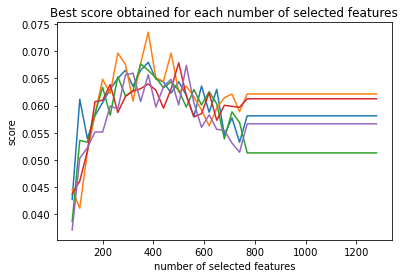

In [23]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    N = np.arange(80,1300,30)
    subset, train_score = MIM(y_train, x_train, FamiliesClusters, compute_precision,True,N, 3, plot=True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

# Anova F test

(2688, 768) (695, 768) (2688,) (695,)
(2713, 768) (670, 768) (2713,) (670,)
(2697, 768) (686, 768) (2697,) (686,)
(2718, 768) (665, 768) (2718,) (665,)
(2716, 768) (667, 768) (2716,) (667,)
training 0.08264143902719226 0.0024610118047373414
test 0.13970224242305862 0.01892021673523378


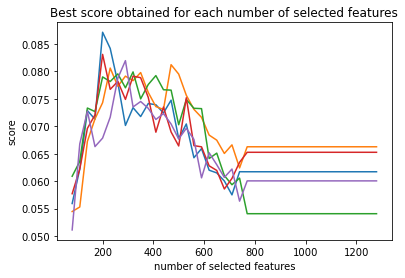

In [24]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    N = np.arange(80,1300,30)
    subset, train_score = ANOVA(y_train, x_train, FamiliesClusters, compute_ratio,True,N, plot=True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

# Stimulated annealing

(2688, 768) (695, 768) (2688,) (695,)


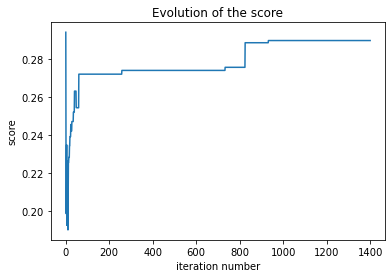

(2713, 768) (670, 768) (2713,) (670,)


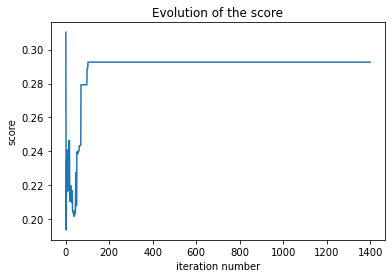

(2697, 768) (686, 768) (2697,) (686,)


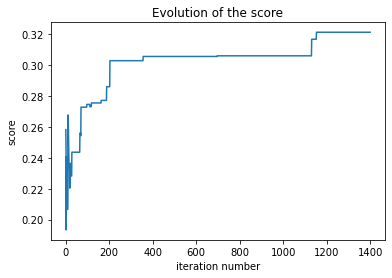

(2718, 768) (665, 768) (2718,) (665,)


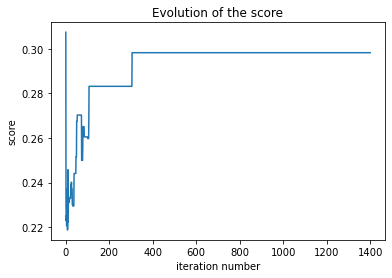

(2716, 768) (667, 768) (2716,) (667,)


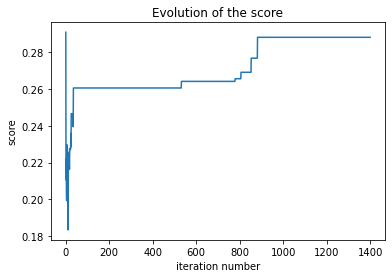

training 0.2979863576223899 0.01209876300133123
test 0.09477592196541806 0.014887519135407944


In [25]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    subset, train_score = stimulated_annealing(y_train, x_train, FamiliesClusters, compute_sensitivity,True, 1400, 0.1, 1, True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

# Genetic feature selection algorithm

In [26]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    subset, train_score = genetic_fs(y_train,x_train,FamiliesClusters,compute_sensitivity,True, 500, 0.5, 0.2, 50, 3, True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

(2688, 768) (695, 768) (2688,) (695,)


/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dormann/Desktop/GitHub/src/pred_score.py", line 326, in fit
    Z = ward(corr_expr)
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 834, in ward
    return linkage(y, method='ward', metric='euclidean')
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 1065, in linkage
    raise ValueError("The condensed distance matrix must contain only "
ValueError: The condensed distance matrix must contain only finite values.

  warnings.warn("E

/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dormann/Desktop/GitHub/src/pred_score.py", line 326, in fit
    Z = ward(corr_expr)
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 834, in ward
    return linkage(y, method='ward', metric='euclidean')
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 1065, in linkage
    raise ValueError("The condensed distance matrix must contain only "
ValueError: The condensed distance matrix must contain only finite values.

  warnings.warn("E

/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dormann/Desktop/GitHub/src/pred_score.py", line 326, in fit
    Z = ward(corr_expr)
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 834, in ward
    return linkage(y, method='ward', metric='euclidean')
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 1065, in linkage
    raise ValueError("The condensed distance matrix must contain only "
ValueError: The condensed distance matrix must contain only finite values.

  warnings.warn("E

/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dormann/Desktop/GitHub/src/pred_score.py", line 326, in fit
    Z = ward(corr_expr)
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 834, in ward
    return linkage(y, method='ward', metric='euclidean')
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 1065, in linkage
    raise ValueError("The condensed distance matrix must contain only "
ValueError: The condensed distance matrix must contain only finite values.

  warnings.warn("E

/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/dormann/Desktop/GitHub/src/pred_score.py", line 326, in fit
    Z = ward(corr_expr)
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 834, in ward
    return linkage(y, method='ward', metric='euclidean')
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/scipy/cluster/hierarchy.py", line 1065, in linkage
    raise ValueError("The condensed distance matrix must contain only "
ValueError: The condensed distance matrix must contain only finite values.

  warnings.warn("E

KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/multiprocess/process.py", line 315, in _bootstrap
    self.run()
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/multiprocess/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/multiprocess/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/multiprocess/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages

  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 1046, in __call__
    while self.dispatch_one_batch(iterator):
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 861, in dispatch_one_batch
    self._dispatch(tasks)
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 779, in _dispatch
    job = self._backend.apply_async(batch, callback=cb)
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 208, in apply_async
    result = ImmediateResult(func)
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/joblib/_parallel_backends.py", line 572, in __init__
    self.results = batch()
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262, in __call__
    return [func(*args, **kwargs)
  File "/Users/dormann/opt/anaconda3/lib/python3.9/site-packages/joblib/parallel.py", line 262

# Mutual information and stimulated annealing

In [ ]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    subset, train_score = MI_stimulated_annealing(y_train,x_train, FamiliesClusters, compute_sensitivity,True, np.array([400]), 3, 5000, 0.05, 1, True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)

# Mutual information and genetic feature selection

In [ ]:
score_training = []
score_testing = []

#CV with kfold
kfold = 5
for i in range(0,kfold):
    #Get split data
    x_test = np.squeeze(split_x[i])
    y_test = np.squeeze(split_y[i])
    x_train_temp = np.squeeze(np.delete(split_x, i))
    y_train_temp = np.squeeze(np.delete(split_y, i))
    
    
    #Fuse the training fold
    for j in range(0,kfold-1):
        x_train_temp[j] = np.squeeze(np.array(x_train_temp[j]))
        y_train_temp[j] = np.squeeze(np.array(y_train_temp[j]))
     
    x_train = x_train_temp[0].T
    y_train = y_train_temp[0]
    for j in range(1,kfold-1):
        x_train = np.c_[x_train,x_train_temp[j].T]
        y_train = np.append(y_train,y_train_temp[j])
    
    x_train = x_train.T
    print(np.shape(x_train),np.shape(x_test),np.shape(y_train),np.shape(y_test))
    
    #Run feature selection on training set
    subset, train_score = MI_genetic_fs(y_train,x_train, FamiliesClusters, compute_sensitivity,True, np.array([700]), 3,  300, 0.5, 0.2, 120, 3, True)
    
    #Evaluate feature selection on test set
    model = FamiliesClusters(np.unique(y_test),compute_ratio,True)
    pred = model.fit_predict(x_test[:, subset],y_test)
    test_score = model.score(x_test,y_test)
    
    score_training = np.append(score_training, train_score)
    score_testing = np.append(score_testing, test_score)

mean_score_training, std_score_training = np.mean(score_training), np.std(score_training)    
print('training', mean_score_training, std_score_training)

mean_score_test, std_score_test = np.mean(score_testing), np.std(score_testing)    
print('test', mean_score_test, std_score_test)